In [10]:
# Import packages
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 2500
pd.set_option("display.max_columns", None)

# Dataset

In [11]:
### create coords dataframe

path = "../data/raw/costa/COSTA well_heads.csv"
data = pd.read_csv(path)
print(data.shape)

data.drop(
    columns=["Unnamed: 0", "Z_top", "Z_bottom", "YEAR", "KB", "TD", "TYPE"],
    inplace=True,
)

rename_dict = {"WELLNAME": "cat", "X": "x", "Y": "y"}
data.rename(columns=rename_dict, inplace=True)

print(data.shape)
data.head()

(430, 10)
(430, 3)


,cat,x,y
0,Inj-1,49374.998177,75374.998596
1,Inj-2,49374.998177,77874.996691
2,Inj-3,54374.999129,75374.998596
3,Inj-4,54374.999129,77874.996691
4,Inj-5,44374.998415,75374.998596


In [12]:
### create coords dataframe

path = "../data/raw/costa/COSTA Well Heads.prn" 
data1 = pd.read_csv(path, sep="\s+")
print(data1.shape)

rename_dict = {"Well": "cat"}
data1.rename(columns=rename_dict, inplace=True)

data1.columns = [col.lower() for col in data1.columns]

data1.drop(columns=["kb", "td"], inplace=True)

print(data1.shape)
data1.head()

(42, 5)
(42, 3)


,cat,x,y
0,HW-1,69895,61474
1,HW-2,97263,113263
2,HW-3,52211,84211
3,HW-4,52632,95579
4,HW-5,66947,98947


In [13]:
### concat coords dataframes

df = pd.concat([data1, data])
df["cat"] = df["cat"].str.lower()

print(df.shape)

df.to_csv('../data/interim/costa_coords.csv', index=False)

pd.concat([df.head(3), df.tail(2)])

(472, 3)


,cat,x,y
0,hw-1,69895.000000,61474.000000
1,hw-2,97263.000000,113263.000000
2,hw-3,52211.000000,84211.000000
428,well-247,56874.997224,89124.997644
429,well-248,51874.998653,91624.996929


In [5]:
### load appraisal well data

path = "../data/raw/costa/COSTA Synthetic Production Monthly.xlsx"

data = pd.DataFrame()

# concat sheets
sheet_names = [
    "Appraisal Wells",
    "Production Wells",
    "Peripheral Water Injectors",
    "Infill Water Injectors",
]

for sheet_name in sheet_names:
    
    df = pd.read_excel(path, sheet_name=sheet_name, header=4)
    df["group"] = sheet_name
    df.dropna(axis=1, how="all", inplace=True)
    
    print(sheet_name, df.shape)

    data = pd.concat([data, df], ignore_index=True)

# rename columns
rename_dict = {
    "well": "cat", 
    "gas oil ratio sc (ft³/bbl)": "gor",
    "gas rate sc - monthly (ft³/day)": "gas",
    "oil rate sc - monthly (bbl/day)": "oil",
    "water cut sc - %": "watercut",
    "water rate sc - monthly (bbl/day)": "water",
    "well bottom-hole pressure (psi)": 'bhp'
    }
data.columns = [col.lower() for col in data.columns]
data.rename(columns=rename_dict, inplace=True)

# rename data in "cat" and "group"
data["cat"] = data["cat"].str.lower()
dictionary = {
    "Appraisal Wells": "P",
    "Production Wells": "P",
    "Peripheral Water Injectors": "I",
    "Infill Water Injectors": "I",
}
data["group"] = data["group"].map(dictionary)

print(data.shape)

Appraisal Wells (6120, 9)
Production Wells (47868, 9)
Peripheral Water Injectors (22272, 5)
Infill Water Injectors (16860, 5)
(93120, 9)


,cat,date,gor,gas,oil,watercut,water,bhp,group
0,hw-3,2020-02-01,731.414978,3.660375e+06,5004.512533,0.000043,0.002136,3274.055729,P
1,hw-3,2020-03-01,731.414978,3.782299e+06,5171.207386,0.000022,0.001117,3237.286417,P
2,hw-3,2020-04-01,731.414978,3.571577e+06,4883.105894,0.000014,0.000673,3221.117826,P
3,hw-3,2020-05-01,731.414978,3.653935e+06,4995.706858,0.000044,0.002196,3196.397707,P
4,hw-3,2020-06-01,731.414978,3.611093e+06,4937.133294,0.000101,0.004971,3187.041537,P


In [8]:
data["water_inj"] = np.where(data["group"] == "I", data["water"], np.nan)
data["water"] = np.where(data["group"] == "P", data["water"], np.nan)

data["bhp_inj"] = np.where(data["group"] == "I", data["bhp"], np.nan)
data["bhp"] = np.where(data["group"] == "P", data["bhp"], np.nan)

pd.concat([data.head(3), data.tail(2)])

,cat,date,gor,gas,oil,watercut,water,bhp,group,water_inj,bhp_inj
0,hw-3,2020-02-01,731.414978,3.660375e+06,5004.512533,0.000043,0.002136,3274.055729,P,NaN,NaN
1,hw-3,2020-03-01,731.414978,3.782299e+06,5171.207386,0.000022,0.001117,3237.286417,P,NaN,NaN
2,hw-3,2020-04-01,731.414978,3.571577e+06,4883.105894,0.000014,0.000673,3221.117826,P,NaN,NaN
93118,inj-1,2049-12-01,NaN,NaN,NaN,NaN,NaN,NaN,I,NaN,NaN
93119,inj-1,2050-01-01,NaN,NaN,NaN,NaN,NaN,NaN,I,NaN,NaN


In [9]:
path = "../data/interim/costa_data.csv"
data.to_csv(path, index=False)

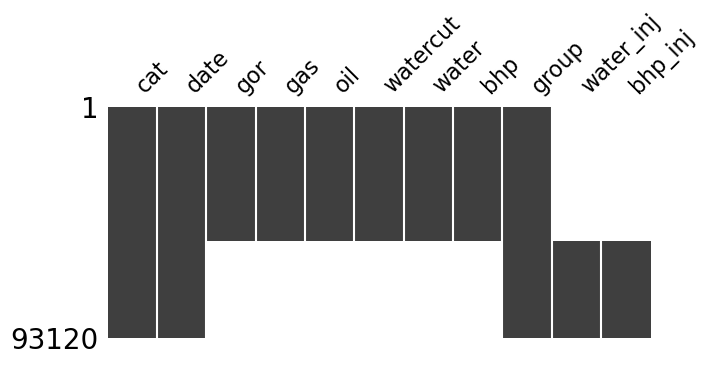

In [10]:
import missingno as msno

# Визуализируем матрицу Missingno
msno.matrix(data, sparkline=False, figsize=(7, 3));

In [18]:
data.groupby('group').count()

,cat,date,gor,gas,oil,watercut,water,bhp,water_inj,bhp_inj
group,,,,,,,,,,
I,39132,39132,0,0,0,0,0,0,39132,39132
P,53988,53988,53988,53988,53988,53988,53988,53988,0,0


In [9]:
test = data[data["date"] >= "2048-02-01"].copy()
print("test shape:", test.shape)

path = "../data/interim/costa_test_org.csv"
test.to_csv(path, index=False)

test shape: (10728, 11)


In [10]:
for col in ["gor", "gas", "oil", "watercut", "water", "bhp"]:
    data[col] = np.where(data["date"] < "2048-02-01", data[col], np.nan)

<Axes: >

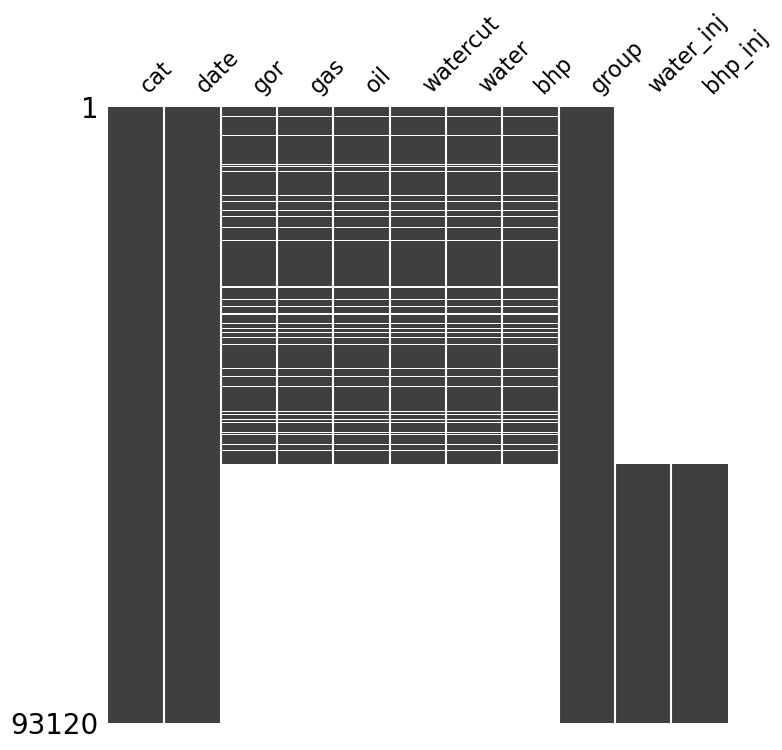

In [11]:
msno.matrix(data, sparkline=False, figsize=(8, 8))

In [12]:
train = data[data["date"] < "2048-02-01"].copy()
print("train shape:", train.shape)

path = "../data/interim/costa_train.csv"

train.to_csv(path, index=False)

train shape: (82392, 11)


In [13]:
test = data[data["date"] >= "2048-02-01"].copy()
print("test shape:", test.shape)

path = "../data/interim/costa_test.csv"

test.to_csv(path, index=False)

test shape: (10728, 11)
